In [1]:
import xarray as xr
import cfgrib
import numpy as np
import matplotlib.pyplot as plt

from data_processor import DataProcessor
from regressor import Regressor

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp), axis=-1)

In [4]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 2
fh = 1

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=True)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [5]:
len(X.shape) > 1

True

In [6]:
X.shape, y.shape

((1430, 25, 45, 5, 2, 6), (1430, 25, 45, 1, 6))

In [7]:
X.shape, y.shape

((1430, 25, 45, 5, 2, 6), (1430, 25, 45, 1, 6))

<LINEAR>
RMSE t2m: 2.85181
RMSE sp: 1.37269
RMSE tcc: 0.25867
RMSE u10: 1.51421
RMSE v10: 2.35038
RMSE tp: 0.00024


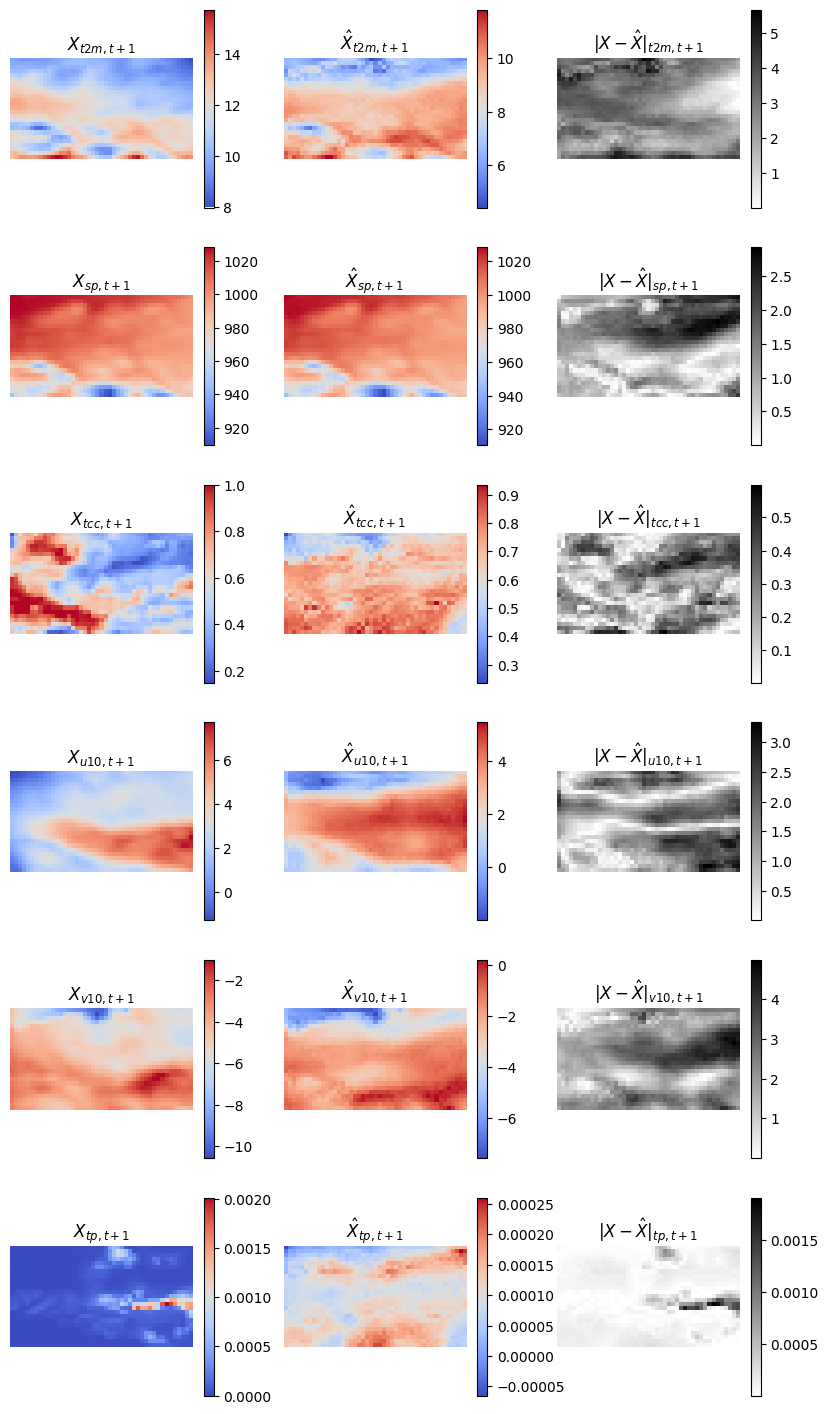

Evaluation metrics for entire test set:
RMSE t2m: 2.8
RMSE sp: 1.134
RMSE tcc: 0.251
RMSE u10: 1.364
RMSE v10: 1.188
RMSE tp: 0.0



In [8]:
available_reg = ['linear'] #, 'lasso', 'ridge', 'elastic_net']
for reg in available_reg:
    print(f'<{reg.upper()}>')
    linearreg = Regressor(X.shape, fh, feature_list, regressor_type=reg)
    linearreg.train(X_train, y_train)
    _ = linearreg.predict_and_evaluate(X_test, y_test, max_samples=1)
    print()